# Z3 SAT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Tutorial.ipynb` notebook.

In [ ]:
!pip3 install z3-solver

In [1]:
from itertools import combinations
from z3 import *
from utils import *

## Useful contraints

In [2]:
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]
    # tutte le combinazioni possibili di lunghezza 2

def exactly_one(bool_vars):
    return at_most_one(bool_vars) + [at_least_one(bool_vars)]

## Knights and Knaves

In [3]:
# Which are the variables?
# Secondo il tutor in questo caso non è necessario usare l'exclusive or, però si potrebbe anche aggiungere
AisKnight = Bool("AisKnight")
BisKnight = Bool("BisKnight")

s = Solver()

# Encode A's statement
statement = Or(AisKnight, Not(BisKnight))

# If A is a knight, then A's statement is true
constraint1 = Implies(AisKnight, statement)

# If A is a knave, then A's statement is a lie
constraint2 = Implies(Not(AisKnight), Not(statement))

# Unicity check
# s.add(Not(And(AisKnight, BisKnight)))
s.add(constraint1)
s.add(constraint2)

outcome = s.check()

if outcome == sat:
    print(s.model())
else: 
    print('the model is not sat')


[AisKnight = True, BisKnight = False]


## Coloring graph

Another famous problem is the [coloring graph](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjAlpGV4az2AhUP2aQKHY_5BQwQFnoECAQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGraph_coloring&usg=AOvVaw0F_XS2AN3uz4G-IJx5Q8j0). 

Given a graph $({v_1,...,v_n},E)$ and $d$ colors, we need to assign a color to each vertex, s.t. if $(v_i,v_j) ∈ E$ then color of $v_i$ is different from color of $v_j$. 

In [25]:
def coloring_graph_sat1(n, d, E):

    # Create the variables, x_i_j = 1 iff vertex i is colored with color j.
    v = [[Bool(f'v_{i,j}') for j in range(d)] for i in range(n)] # nested list comprehension
    
    # v = [Bool(f'v_{i,j}') for j in range(d) for i in range(n)] # in questo caso mi crea un'unica lista, non liste innestate

    # Solver instance
    s = Solver()
    
    # Each vertex has at least one color 
    for i in range(n):
        s.add(Or(v[i])) # ogni volta che faccio l'add AND è sottinteso per le clause 
        # Questa clausola è formata dalla disgiunzione (Or) di tutte le variabili v[i][j] relative al vertice i
    
    # Each edge must have different colors in its vertices
    for i, j in E:  # E is a tuple che ha tutte le coppie adiacenti
        for k in range(d):
            s.add(Not(And(v[i][k], v[j][k])))

    if s.check() == sat:
        return s.model()
    else:
        return 'Error'

In [26]:
def coloring_graph_sat(n, d, E):

    # Create the variables, x_i_j = 1 iff vertex i is colored with color j.
    v = [[Bool(f'v_{i,j}') for j in range(d)] for i in range(n)] # nested list comprehension
    
    # v = [Bool(f'v_{i,j}') for j in range(d) for i in range(n)] # in questo caso mi crea un'unica lista, non liste innestate

    # Solver instance
    s = Solver()
    
    # Each vertex has at least one color 
    for i in range(n):
        s.add(Or(v[i])) # ogni volta che faccio l'add AND è sottinteso per le clause 
        # Questa clausola è formata dalla disgiunzione (Or) di tutte le variabili v[i][j] relative al vertice i
    
    # Each edge must have different colors in its vertices
    for i, j in E:  # E is a tuple che ha tutte le coppie adiacenti
        for k in range(d):
            s.add(Not(And(v[i][k], v[j][k])))

    if s.check() == sat:
        m = s.model()
    else:
        return 'Error'
    
    return [(i,j) for i in range(n) for j in range(d) if m.evaluate(v[i][j])] # solo se la variabile booleana viene valutata come vera
    # serve a restituire una tupla contenente il vertice e il colore assegnato dal solver

In [18]:
v = [[Bool(f'v_{i,j}') for j in range(4)] for i in range(10)]
print(v)
for i in range(10):
    print(v[i])

[[v_(0, 0), v_(0, 1), v_(0, 2), v_(0, 3)], [v_(1, 0), v_(1, 1), v_(1, 2), v_(1, 3)], [v_(2, 0), v_(2, 1), v_(2, 2), v_(2, 3)], [v_(3, 0), v_(3, 1), v_(3, 2), v_(3, 3)], [v_(4, 0), v_(4, 1), v_(4, 2), v_(4, 3)], [v_(5, 0), v_(5, 1), v_(5, 2), v_(5, 3)], [v_(6, 0), v_(6, 1), v_(6, 2), v_(6, 3)], [v_(7, 0), v_(7, 1), v_(7, 2), v_(7, 3)], [v_(8, 0), v_(8, 1), v_(8, 2), v_(8, 3)], [v_(9, 0), v_(9, 1), v_(9, 2), v_(9, 3)]]
[v_(0, 0), v_(0, 1), v_(0, 2), v_(0, 3)]
[v_(1, 0), v_(1, 1), v_(1, 2), v_(1, 3)]
[v_(2, 0), v_(2, 1), v_(2, 2), v_(2, 3)]
[v_(3, 0), v_(3, 1), v_(3, 2), v_(3, 3)]
[v_(4, 0), v_(4, 1), v_(4, 2), v_(4, 3)]
[v_(5, 0), v_(5, 1), v_(5, 2), v_(5, 3)]
[v_(6, 0), v_(6, 1), v_(6, 2), v_(6, 3)]
[v_(7, 0), v_(7, 1), v_(7, 2), v_(7, 3)]
[v_(8, 0), v_(8, 1), v_(8, 2), v_(8, 3)]
[v_(9, 0), v_(9, 1), v_(9, 2), v_(9, 3)]


In [9]:
instance1 = {
        "n" : 5,
        "d": 3,
        "E" : [
            (0, 2),
            (0, 4),
            (1, 2),
            (1, 4),
            (2, 3), 
            (3, 4)
        ]
    }
instance2 = {
        "n":10,
        "d":3,
        "E":[
            (0, 1),
            (0, 4),
            (0, 5),
            (1, 2),
            (1, 6),
            (2, 7),
            (2, 3),
            (3, 8),
            (3, 4),
            (4, 9),
            (9, 6),
            (9, 7),
            (6, 8),
            (5, 7),
            (5, 8), 
        ]
}

In [10]:
instance = instance2

In [28]:
coloring_graph_sat1(instance['n'], instance['d'], instance['E'])
# vedo tutte le assegnazioni, NON LEGGIBILE!!

[v_(7, 1) = True,
 v_(5, 2) = True,
 v_(2, 2) = False,
 v_(0, 0) = True,
 v_(3, 1) = False,
 v_(5, 0) = False,
 v_(6, 2) = False,
 v_(6, 0) = False,
 v_(9, 0) = True,
 v_(7, 0) = False,
 v_(8, 1) = False,
 v_(0, 1) = False,
 v_(4, 0) = False,
 v_(8, 2) = False,
 v_(9, 1) = False,
 v_(1, 2) = True,
 v_(2, 0) = True,
 v_(3, 2) = True,
 v_(2, 1) = False,
 v_(7, 2) = False,
 v_(4, 2) = False,
 v_(8, 0) = True,
 v_(5, 1) = False,
 v_(9, 2) = False,
 v_(0, 2) = False,
 v_(4, 1) = True,
 v_(6, 1) = True,
 v_(3, 0) = False,
 v_(1, 1) = False,
 v_(1, 0) = False]

In [29]:
coloring_graph_sat(instance['n'], instance['d'], instance['E'])
# lista di tuple, (vertice, colore)

[(0, 0),
 (1, 2),
 (2, 0),
 (3, 2),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 0),
 (9, 0)]

CPU times: total: 46.9 ms
Wall time: 49 ms


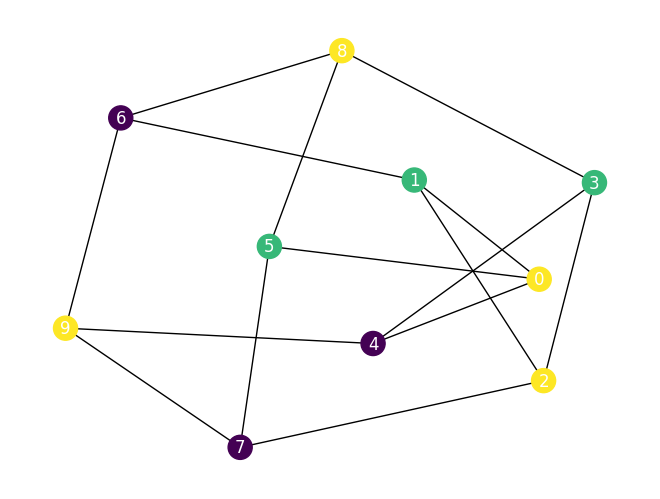

In [32]:
%%time
display_color_graph(sol = coloring_graph_sat(instance2["n"], instance2["d"], instance2["E"]), E = instance2["E"])
# # funzione dell'utils

## N-Queens

The [n-queens problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle) is the problem of placing n chess queens in a $nxn$ chessboard so that no two queens threaten each other. In light of this, the solution requires that no two queens share the same row, column, or diagonal.

In [32]:
def nqueens_sat(n):
    # Create all the variables
    p = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(n)]

    # Create the solver instance
    s = Solver()

    # Exactly one on each row and column
    for i in range(n):
        s.add(exactly_one(p[i]))
        s.add(exactly_one([p[j][i] for j in range(n)]))

    # Add the diagonal constraints
    for i in range(n - 1):
        diag_ru_ll = []
        diag_lu_rl = []
        diag_ll_ru = []
        diag_rl_lu = []
        for j in range(n - i):
            # tutte le diagonali partono dal centro e poi fanno quattro movimenti diversi
            # 2 movimenti per diagonale
            # possono scendere o salire
            diag_ll_ru += [p[i + j][j]]
            diag_lu_rl += [p[n - 1 - (i + j)][j]]
            diag_rl_lu += [p[i + j][n - 1 - j]]
            diag_ru_ll += [p[n - 1 - (i + j)][n - 1 - j]]
        s.add(at_most_one(diag_ru_ll))
        s.add(at_most_one(diag_lu_rl))
        s.add(at_most_one(diag_rl_lu))
        s.add(at_most_one(diag_ll_ru))
    
        print(diag_ll_ru, diag_lu_rl, diag_rl_lu, diag_ru_ll)

    s.check()

    m = s.model()
    return [(i, j) for i in range(n) for j in range(n) if m.evaluate(p[i][j])]

In [33]:
nqueens_sat(4)

[x_0_0, x_1_1, x_2_2, x_3_3] [x_3_0, x_2_1, x_1_2, x_0_3] [x_0_3, x_1_2, x_2_1, x_3_0] [x_3_3, x_2_2, x_1_1, x_0_0]
[x_1_0, x_2_1, x_3_2] [x_2_0, x_1_1, x_0_2] [x_1_3, x_2_2, x_3_1] [x_2_3, x_1_2, x_0_1]
[x_2_0, x_3_1] [x_1_0, x_0_1] [x_2_3, x_3_2] [x_1_3, x_0_2]


[(0, 2), (1, 0), (2, 3), (3, 1)]

In [29]:
%%time
display_nqueens(nqueens_sat(4))

. . ♛ . 
♛ . . . 
. . . ♛ 
. ♛ . . 
CPU times: total: 15.6 ms
Wall time: 26 ms


## Sudoku

[Sudoku](https://en.wikipedia.org/wiki/Sudoku) is a logic-based, combinatorial number-placement puzzle. In classic sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid contain all of the digits from 1 to 9. 

In [4]:
# Sudoku instances, '0's correspond to empty cells

instance1 = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
             (0, 0, 0, 5, 1, 0, 0, 0, 7),
             (0, 8, 9, 0, 0, 0, 0, 4, 0),
             (0, 0, 0, 0, 0, 0, 2, 0, 8),
             (0, 6, 0, 2, 0, 1, 0, 5, 0),
             (1, 0, 2, 0, 0, 0, 0, 0, 0),
             (0, 7, 0, 0, 0, 0, 5, 2, 0),
             (9, 0, 0, 0, 6, 5, 0, 0, 0),
             (0, 4, 0, 9, 7, 0, 0, 0, 0))

instance2 = ((0, 0, 0, 0, 9, 0, 1, 0, 0),
             (2, 8, 0, 0, 0, 5, 0, 0, 0),
             (7, 0, 0, 0, 0, 6, 4, 0, 0),
             (8, 0, 5, 0, 0, 3, 0, 0, 6),
             (0, 0, 1, 0, 0, 4, 0, 0, 0),
             (0, 7, 0, 2, 0, 0, 0, 0, 0),
             (3, 0, 0, 0, 0, 1, 0, 8, 0),
             (0, 0, 0, 0, 0, 0, 0, 5, 0),
             (0, 9, 0, 0, 0, 0, 0, 7, 0))

instance3 = ((0, 7, 0, 0, 0, 0, 0, 4, 9),
             (0, 0, 0, 4, 0, 0, 0, 0, 0),
             (4, 0, 3, 5, 0, 7, 0, 0, 8),
             (0, 0, 7, 2, 5, 0, 4, 0, 0),
             (0, 0, 0, 0, 0, 0, 8, 0, 0),
             (0, 0, 4, 0, 3, 0, 5, 9, 2),
             (6, 1, 8, 0, 0, 0, 0, 0, 5),
             (0, 9, 0, 1, 0, 0, 0, 3, 0),
             (0, 0, 5, 0, 0, 0, 0, 0, 7))

instance4 = ((0, 0, 0, 0, 0, 6, 0, 0, 0),
             (0, 5, 9, 0, 0, 0, 0, 0, 8),
             (2, 0, 0, 0, 0, 8, 0, 0, 0),
             (0, 4, 5, 0, 0, 0, 0, 0, 0),
             (0, 0, 3, 0, 0, 0, 0, 0, 0),
             (0, 0, 6, 0, 0, 3, 0, 5, 4),
             (0, 0, 0, 3, 2, 5, 0, 0, 6),
             (0, 0, 0, 0, 0, 0, 0, 0, 0),
             (0, 0, 0, 0, 0, 0, 0, 0, 0))

In [65]:
def sudoku_sat(instance):
    # All the variables we need: for each cell, nine variables that determine which digit must be assigned.
    sudoku = [[[Bool(f"v_{i}_{j}_{k}") for k in range(9)] for j in range(9)] for i in range(9)]

    print(type(instance)) # l'instanza è una tupla di tuple, per ogni riga ha una tupla, e due elementi della tupla sono un intero
    print(instance[0][0])

    print(sudoku[0][5][instance[0][5] - 1])  # [v_0_0_0, v_0_0_1, v_0_0_2, v_0_0_3, v_0_0_4, v_0_0_5, v_0_0_6, v_0_0_7, v_0_0_8]

    s = Solver()

    # A cell has only one value
    for i in range(9):
        for j in range(9):
            s.add(exactly_one(sudoku[i][j]))
    

    
    # Each value is used only once in a row
    for j in range(9):
        for k in range(9):
            s.add(exactly_one([sudoku[i][j][k] for i in range(9)]))

    # Each value used exactly once in each column
    for i in range(9):
        for k in range(9):
            s.add(exactly_one([sudoku[i][j][k] for j in range(9)]))

    # Each value used exactly once in each 3x3 grid.
    for i in range(3):
        for j in range(3):
            for k in range(9):
                s.add(exactly_one([sudoku[i*3 + a][j*3 + b][k] for a in range(3) for b in range(3)]))

    # serve solo a inserire in and i valori già preimpostati, come?
    # dichia rando le variabili booleane i,j con k-1 poichè abbiamo k che va da 0 a 8 per i numeri da 1 a 9
    # Some numbers are already available
    for i in range(9):
        for j in range(9):
            if instance[i][j] > 0:
                s.add(sudoku[i][j][instance[i][j] - 1])
    
    # questo mi serve a returnare una lista di liste per ogni riga, con il valore corretto che sarebbe k+1
    if s.check() == sat:
        m = s.model()
        sol = []
        for i in range(9):
            sol.append([])
            for j in range(9):
                for k in range(9):
                    if m.evaluate(sudoku[i][j][k]):
                        sol[i].append(k+1)
        return sol
    else:
        print("Failed to solve")


In [66]:
sudoku_sat(instance=instance4)

<class 'tuple'>
0
v_0_5_5


[[3, 8, 7, 4, 5, 6, 2, 1, 9],
 [1, 5, 9, 2, 3, 7, 4, 6, 8],
 [2, 6, 4, 1, 9, 8, 5, 3, 7],
 [7, 4, 5, 6, 1, 2, 8, 9, 3],
 [8, 1, 3, 5, 4, 9, 6, 7, 2],
 [9, 2, 6, 8, 7, 3, 1, 5, 4],
 [4, 7, 1, 3, 2, 5, 9, 8, 6],
 [6, 3, 2, 9, 8, 1, 7, 4, 5],
 [5, 9, 8, 7, 6, 4, 3, 2, 1]]

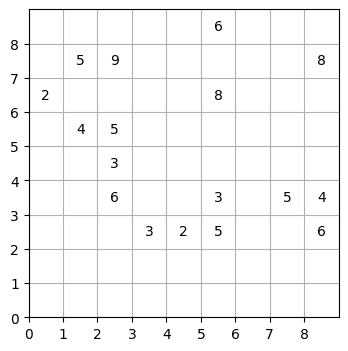

In [61]:
# Select the instance you want to solve
instance = instance4
display_sudoku(instance)

<class 'tuple'>
0
v_0_5_5


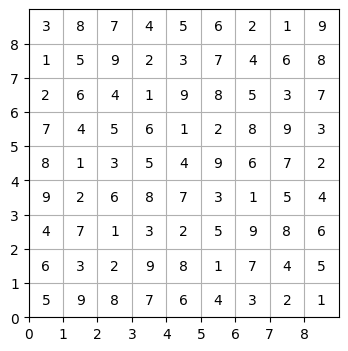

CPU times: total: 1.58 s
Wall time: 1.59 s


In [67]:
%%time
display_sudoku(sudoku_sat(instance))

## Nurse scheduling problem

In the next example, called [nurse scheduling problem](https://en.wikipedia.org/wiki/Nurse_scheduling_problem), a hospital supervisor needs to create a schedule for $n$ nurses over a fixed day period, subject to the following conditions:

- Each day is divided into three 8-hour shifts.
- Every day, each shift is assigned to a single nurse, and no nurse works more than one shift.
- Each nurse is assigned to a minimum amount of shifts during the given days period.


In [3]:
instance1 = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 3
}

instance2 = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 4
}

### Advanced useful contraints

In [5]:
def at_least_k_np(bool_vars, k):
    return at_most_k_np([Not(var) for var in bool_vars], len(bool_vars)-k) # l'inverso e il complemento

def at_most_k_np(bool_vars, k):
    return And([Or([Not(x) for x in X]) for X in combinations(bool_vars, k + 1)])
    # nel senso che non esiste nessuna combinazione di k+1 variabili booleane che sia vera
    # per avere l'Or falso basta che ce ne sia almeno una sempre quindi falsa, in modo tale che le combinazioni quindi siano al massimo k 

def exactly_k_np(bool_vars, k):
    return And(at_most_k_np(bool_vars, k), at_least_k_np(bool_vars, k))

## Try it yourself!

Try to model the variables and constraints to solve the nurse scheduling problem, starting from the examples listed above. 

If possible, shifts should be distributed evenly and fairly, so that each nurse works the minimum amount of them. If this is not possible, because the total number of shifts is not divisible by the number of nurses, some nurses will be assigned one more shift, without crossing the maximum number of shifts which can be worked by each nurse

In [9]:
def nurse_scheduling_sat(num_nurses, num_shifts, num_days, timeout = None):

    # Create all the variables, shifts[i, j, k] is True if shift k is assigned to nurse i on day j.
    shifts = [[[Bool(f's_{i}_{j}_{k}') for k in range(num_shifts)] for j in range(num_days)] for i in range(num_nurses)]
    
    s = Solver()

    # This gives the solver a maximum time to find a solution, if it is exceeded the solver will report that it didn't find a solution
    # with the set method we can set other parameters about the solver we can costumize
    # in the exam we will have a time within the solver has to find a solution
    if timeout:
        s.set('timout', timeout)
    
    # In each shift can work just one nurse
    for j in range(num_days):
        for k in range(num_shifts):
            s.add(exactly_one([shifts[i][j][k] for i in range(num_nurses)]))
    
    # Each nurse can work just one shift per day 
    for i in range(num_nurses):
        for j in range(num_days):
            s.add(at_most_one(shifts[i][j]))
    
    
    # Fair assignment of shifts, dobbiamo trovare un modo per dire -> ok l'assegnazione delle ore per tutte le infermiere è giusta
    # Fair assignment of shifts
    min_n_shifts_per_nurse = (num_days * num_shifts) // num_nurses
    if (num_days * num_shifts) % num_nurses == 0:
        max_n_shifts_per_nurse = min_n_shifts_per_nurse
    else:
        max_n_shifts_per_nurse = min_n_shifts_per_nurse + 1


    for i in range(num_nurses):
        shifts_worked = []
        for j in range(num_days):
            for k in range(num_shifts):
                shifts_worked.append(shifts[i][j][k])
        s.add(at_least_k_np(shifts_worked, min_n_shifts_per_nurse))
        s.add(at_most_k_np(shifts_worked, max_n_shifts_per_nurse))
    

    if s.check() == sat:
        m = s.model()
        return [(i, j, k) for i in range(num_nurses) for j in range(num_days) for k in range(num_shifts) if m.evaluate(shifts[i][j][k])]
    else:
        print("unsat")



In [41]:
print(math.floor(9/2))
print(math.ceil(9/2))

4
5


In [7]:
instance = instance1

In [10]:
nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"])

[(0, 0, 0),
 (0, 1, 2),
 (0, 2, 2),
 (1, 1, 1),
 (1, 2, 1),
 (2, 0, 2),
 (2, 2, 0),
 (3, 0, 1),
 (3, 1, 0)]

In [11]:
%%time
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

Day 0
  Nurse 0 works shift 0
  Nurse 1 does not work
  Nurse 2 works shift 2
  Nurse 3 works shift 1
Day 1
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 does not work
  Nurse 3 works shift 0
Day 2
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 works shift 0
  Nurse 3 does not work
CPU times: total: 266 ms
Wall time: 250 ms


In [12]:
instance = instance2

In [13]:
%%time
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

Day 0
  Nurse 0 works shift 1
  Nurse 1 does not work
  Nurse 2 works shift 0
  Nurse 3 works shift 2
Day 1
  Nurse 0 does not work
  Nurse 1 works shift 1
  Nurse 2 works shift 0
  Nurse 3 works shift 2
Day 2
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 does not work
  Nurse 3 works shift 0
Day 3
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 works shift 0
  Nurse 3 does not work
CPU times: total: 688 ms
Wall time: 691 ms
